# Load and Preprocess MC_Maze Data

Go from spike times to _smoothed_ spike rates, and save into simple format (npz?).

In [3]:
import os
import time
import numpy as np
from pathlib import Path
from typing import List, Optional, Tuple
from sklearn.model_selection import train_test_split


from brn.mint.model import MINT, MINTSettings
from brn.mint.utils import process_kinematics, bin_data
from brn.mint.generic_config import generic_config
from brn.mint import preprocessing


In [4]:
def get_trial_data(settings: dict, split: str = "train", n_trials: int | None = 50) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Helper function to get trial data from the MC Maze dataset.

    :param settings: dict with key "trialAlignment" which is a list of integers representing the indices
      for each trial relative to its move_onset_time.
    :param split: "train" or "test"
    :param n_trials: Number of trials to return, if None, returns all trials
    :return: S, Z, condition
        S: ndarray of shape (n_trials, n_neurons, n_time_steps), dtype bool with 1 at spike time, 0 otherwise
        Z: ndarray of shape (n_trials, 4 (pos_x, pos_y, vel_x, vel_y), n_time_steps), dtype float
        condition: ndarray of shape (n_trials,), dtype int with condition indices
    """
    datadir = os.getenv("MC_MAZE_DATASET_PATH", str(Path.home() / "Downloads" / "000128"))
    train_path = Path(datadir) / "sub-Jenkins" / "sub-Jenkins_ses-full_desc-train_behavior+ecephys.nwb"
    test_path = Path(datadir) / "sub-Jenkins" / "sub-Jenkins_ses-full_desc-test_ecephys.nwb"

    # Load dataset
    import pynwb
    with pynwb.NWBHDF5IO(test_path if split == "test" else train_path, "r") as io:
        read_nwbfile = io.read()

        # Find the trial info and keep only the subset we want
        trial_info = read_nwbfile.intervals["trials"].to_dataframe()
        trial_info = trial_info[trial_info["split"] == split]

        n_trials = n_trials or len(trial_info)

        # Find unique conditions
        if split == "test":
            condition = -1 * np.ones(n_trials, dtype=int)
        else:
            conds = trial_info.set_index(["trial_type", "trial_version"]).index.tolist()
            cond_list = trial_info.set_index(["trial_type", "trial_version"]).index.unique().tolist()
            cond_list.sort()
            condition = np.array([cond_list.index(_) + 1 for _ in conds[:n_trials]])

        # Get a timestamp vector for all behavior data
        behav_dict = read_nwbfile.processing["behavior"].data_interfaces
        assert np.array_equal(behav_dict["hand_pos"].timestamps[:], behav_dict["hand_vel"].timestamps[:])
        all_ts = behav_dict["hand_pos"].timestamps[:]

        # Find the index where each trial's move period starts
        trial_onsets_beh = np.searchsorted(all_ts, trial_info[:n_trials]["move_onset_time"])

        # Take per-trial data from position and velocity arrays.
        trial_inds = settings["trialAlignment"]
        all_trial_inds = trial_onsets_beh[:, None] + trial_inds[None, :]
        all_trial_ts = np.take(all_ts, all_trial_inds, axis=0)

        all_pos = np.take(behav_dict["hand_pos"].data, all_trial_inds, axis=0)
        all_vel = np.take(behav_dict["hand_vel"].data, all_trial_inds, axis=0)
        Z = np.concatenate((all_pos, all_vel), axis=-1)
        Z = np.transpose(Z, (0, 2, 1))  # Shape -> (n_trials, 4, n_steps)

        # Create a boolean array for spikes
        n_neurons = read_nwbfile.units["spike_times"].data.shape[0]
        n_steps = len(trial_inds)
        S = np.zeros((n_trials, n_neurons, n_steps), dtype=bool)
        for unit_ix in range(n_neurons):
            spike_times = read_nwbfile.units["spike_times"][unit_ix]
            for trial_ix, trial_tvec in enumerate(all_trial_ts):
                trial_spike_times = spike_times[np.logical_and(spike_times >= trial_tvec[0], spike_times <= trial_tvec[-1])]
                spike_inds = np.searchsorted(trial_tvec, trial_spike_times)
                S[trial_ix, unit_ix, spike_inds] = True

    return S, Z, condition


def mc_maze_config(causal):
    # Get some generic settings and hyperparameters.
    [settings, hyper_params] = generic_config()

    # Determine which time period of raw data should be loaded on each trial
    settings["trialAlignment"] = np.arange(-800, 901, 1)

    # Determine which time period should be used to evaluate performance
    settings["testAlignment"] = np.arange(-250, 451, 1)

    # Hyperparameters related to learning neural trajectories.
    hyper_params["trajectoriesAlignment"] = np.arange(-500, 701, 1)

    # When learning PSTHs, 'sigma' is the standard deviation of the Gaussian filter.
    hyper_params["sigma"] = 30

    # Dimensionality reduction parameters
    hyper_params["nNeuralDims"] = np.nan
    hyper_params["nCondDims"] = 21
    hyper_params["nTrialDims"] = 1

    # Hyperparameters related to inference.
    hyper_params["Delta"] = 20
    if causal:
        hyper_params["obsWindow"] = 300
    else:
        hyper_params["obsWindow"] = 580

    hyper_params["causal"] = causal

    return [settings, hyper_params]

In [5]:
# Loads in training and test data
[settings, hyper_params] = mc_maze_config(True)
S_all, Z_all, condition_all = get_trial_data(settings, split="train")
S_train, S_val, Z_train, Z_val, cond_train, cond_val = train_test_split(
    S_all, Z_all, condition_all,
    test_size=0.2, random_state=129
)

bin_size=20
observation_window=300
causal=True
trial_alignment=np.arange(-800, 901, 1)
test_alignment=np.arange(-250, 451, 1)
trajectories_alignment=np.arange(-500, 701, 1)
gaussian_sigma=30
neural_dims=np.nan
condition_dims=21
trial_dims=1
min_lambda=1.0
sampling_period=0.001
soft_norm=5.0
min_prob=1e-6
min_rate=0.0
interp_mode=2
interp_max_iters=10
interp_tolerance=0.01
num_rate_bins=2000

S_train, Z_train, cond_train = (
                preprocessing.standard_preprocessing(
                    spikes=S_train,
                    behavior=Z_train,
                    cond_ids=cond_train,
                    trial_alignment=trial_alignment,
                    trajectories_alignment=trajectories_alignment,
                    gaussian_sigma=gaussian_sigma,
                    bin_size=bin_size,
                    soft_norm=soft_norm,
                    sampling_period=sampling_period,
                    trial_dims=trial_dims,
                    neural_dims=neural_dims,
                    condition_dims=condition_dims,
                    )
            )

# Bin both neural and behavioral data to the same resolution
S_train = {
            c: bin_data(x, bin_size, "mean") for c, x in S_train.items()
        }
Z_train = {
            c: bin_data(x, bin_size, "mean") for c, x in Z_train.items()
        }

    
Z_val = process_kinematics(Z_val, trial_alignment)
test_buffer = np.array((-observation_window + 1, 0))
buff_align_start = test_alignment[0] + test_buffer[0]
buff_align_end = test_alignment[-1] + test_buffer[1]
buffered_alignment = np.arange(buff_align_start, buff_align_end + 1)
t_mask = np.isin(trial_alignment, buffered_alignment)
S_val = S_val[:, :, t_mask]
Z_val = Z_val[:, :, t_mask]

S_bar = np.empty(
            (S_val.shape[0], S_val.shape[1], int(S_val.shape[2] / bin_size))
        )
for i in range(len(S_bar)):
    S_bar[i] = bin_data(S_val[i], bin_size, "sum")

Z_bar = np.empty((Z_val.shape[0], Z_val.shape[1], int(Z_val.shape[2] / bin_size)))
for i in range(len(Z_bar)):
    Z_bar[i] = bin_data(Z_val[i], bin_size, method="mean")   # behavior must be MEAN

In [6]:
settings = MINTSettings(
task="mc_maze",
fs=50.0,
obs_window=300,
min_lambda=1.0,
n_rates=2000,
min_rate=0.0,
max_rate=1000,
min_prob=1e-6,
interp_mode=3,
interp_max_iters=10,
interp_tolerance=0.01
)

decoder = MINT(settings)

init


In [7]:
t0 = time.perf_counter()
decoder.fit_mc(
    S_train,
    Z_train,
    cond_train,
)
fit_secs = time.perf_counter() - t0
print(f"Fitting took {fit_secs:.3f} s")

TODO: Fit MINT model...
Fitting took 0.004 s


In [8]:
import numpy as np
import time

# ---- helpers ----
CHANNELS = ["x_pos", "y_pos", "x_vel", "y_vel"]

def r2_per_channel_KT(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """
    Compute R² per channel when arrays are shaped (K, T).
    Returns (K,) with NaN if SS_tot == 0 or not enough valid samples.
    """
    assert y_true.ndim == 2 and y_pred.ndim == 2
    K = min(y_true.shape[0], y_pred.shape[0])
    T = min(y_true.shape[1], y_pred.shape[1])
    if T == 0 or K == 0:
        return np.full(K if K else 1, np.nan, dtype=float)

    yt = y_true[:K, :T]
    yp = y_pred[:K, :T]

    r2 = np.full(K, np.nan, dtype=float)
    for k in range(K):
        valid = (~np.isnan(yt[k, :])) & (~np.isnan(yp[k, :]))
        n = np.count_nonzero(valid)
        if n < 2:
            continue
        yk = yt[k, valid]
        pk = yp[k, valid]
        ss_res = np.sum((yk - pk) ** 2)
        ss_tot = np.sum((yk - np.mean(yk)) ** 2)
        if ss_tot > 0:
            r2[k] = 1.0 - ss_res / ss_tot
    return r2

# ---- evaluation loop ----
count = 0
time_sum = 0.0
trial_r2s = []  # list of (4,) arrays

print("test_features:", S_bar.shape)   # (n_trials, N, T)
print("test_behavior:", Z_bar.shape) # (n_trials, 4, T)

for idx, (feat_NT, beh_KT) in enumerate(zip(S_bar, Z_bar), start=1):
    # feat_NT: (N, T) -> decoder expects (T, N)
    t0 = time.perf_counter()
    X_hat, Z_hat, C_hat, K_hat, Alpha_hat = decoder.predict(feat_NT.T, new_segment=True)
    dt = time.perf_counter() - t0

    # Z_hat is typically (T, 4); transpose to (4, T) to match beh_KT
    Z_hat_KT = Z_hat.T
    

    # Score this trial (channels-by-time)
    r2_vec = r2_per_channel_KT(beh_KT, Z_hat_KT)   # (4,)
    trial_r2s.append(r2_vec)

    time_sum += dt
    count += 1
    r2_str = ", ".join(
        f"{name}: {val:.3f}" if np.isfinite(val) else f"{name}: nan"
        for name, val in zip(CHANNELS, r2_vec)
    )
    print(f"Trial {idx}: {dt:.3f}s | R² -> {r2_str}")

# ---- summary ----
trial_r2s = np.vstack(trial_r2s)                 # (n_trials, 4)
per_feature_mean = np.nanmean(trial_r2s, axis=0) # mean over trials, per channel
overall_mean = np.nanmean(trial_r2s)             # mean over all trials & channels
avg_time = time_sum / max(count, 1)

print("\n=== R² Summary (mean across trials) ===")
for name, val in zip(CHANNELS, per_feature_mean):
    print(f"{name:>6}: {val:.3f}")
print(f"Overall average R²: {overall_mean:.3f}")
print(f"Trial average time: {avg_time:.3f}s")


test_features: (10, 182, 50)
test_behavior: (10, 4, 50)
Trial 1: 0.719s | R² -> x_pos: 0.057, y_pos: 0.421, x_vel: 0.658, y_vel: 0.735
Trial 2: 0.524s | R² -> x_pos: 0.624, y_pos: 0.981, x_vel: 0.820, y_vel: 0.850
Trial 3: 0.505s | R² -> x_pos: 0.903, y_pos: 0.723, x_vel: 0.299, y_vel: 0.810
Trial 4: 0.496s | R² -> x_pos: 0.979, y_pos: 0.770, x_vel: 0.870, y_vel: 0.769
Trial 5: 0.462s | R² -> x_pos: 0.994, y_pos: 0.414, x_vel: 0.967, y_vel: 0.672
Trial 6: 0.503s | R² -> x_pos: 0.308, y_pos: -0.101, x_vel: 0.938, y_vel: 0.466
Trial 7: 0.431s | R² -> x_pos: 0.465, y_pos: -0.075, x_vel: 0.382, y_vel: 0.545
Trial 8: 0.405s | R² -> x_pos: 0.855, y_pos: 0.844, x_vel: 0.799, y_vel: -0.034
Trial 9: 0.392s | R² -> x_pos: 0.861, y_pos: 0.983, x_vel: 0.716, y_vel: 0.969
Trial 10: 0.385s | R² -> x_pos: 0.926, y_pos: 0.639, x_vel: 0.801, y_vel: 0.838

=== R² Summary (mean across trials) ===
 x_pos: 0.697
 y_pos: 0.560
 x_vel: 0.725
 y_vel: 0.662
Overall average R²: 0.661
Trial average time: 0.482s


In [9]:
import matplotlib.pyplot as plt

def _select_trials(
    estimates: dict,
    n_show: int,
    best: bool,
    eval_bin_size: int
) -> List[int]:
    """
    Returns best and worst trials by R^2 value. 
    """
    Z     = estimates['Z']       # (n_trials, 4, T)
    Z_hat = estimates['Z_hat']

    scores = []
    for i in range(len(Z)):
        # bin each trial
        true_b = bin_data(Z[i],     eval_bin_size, method='mean')
        pred_b = bin_data(Z_hat[i], eval_bin_size, method='mean')
        # hstack along time
        tcat = np.hstack([true_b])
        pcat = np.hstack([pred_b])
        # remove NaN columns
        mask = np.any(np.isnan(pcat), axis=0)
        t = tcat[:, ~mask]
        p = pcat[:, ~mask]
        # R2 per feature
        ss_res = np.sum((t - p)**2, axis=1)
        mu     = np.mean(t, axis=1, keepdims=True)
        ss_tot = np.sum((t - mu)**2, axis=1)
        r2     = 1 - ss_res/ss_tot
        scores.append(r2.mean())
    idx = np.argsort(scores)
    if best:
        return idx[-n_show:][::-1].tolist()
    else:
        return idx[:n_show].tolist()


def visualize_mint_predictions(
    estimates: dict,
    trial_indices: Optional[List[int]] = None,
    time_window: Optional[Tuple[int,int]] = None,
    bin_size: int    = 20,
    eval_bin_size: int = 20,
    best: Optional[bool] = True,
    n_show: int = 3
):
    """
    Shows MINT predictions of kinematic variables compared to ground truth.
    """
    behavior = estimates['Z']
    behavior_hat = estimates['Z_hat']
    

    # pick trials if needed
    if trial_indices is None and best is not None:
        trial_indices = _select_trials(estimates, n_show, best, eval_bin_size)
    elif trial_indices is None:
        trial_indices = list(range(min(n_show, len(behavior))))


    # Channel labels
    channel_labels = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
    channel_units = ['(units)', '(units)', '(units/s)', '(units/s)']
    
    fig, axes = plt.subplots(2,2,figsize=(15,10))
    axes = axes.flatten()
    colors = plt.cm.Set1(np.linspace(0,1,len(trial_indices)))
    for ch in range(4):
        ax = axes[ch]
        for ti, c in zip(trial_indices, colors):
            true = behavior[ti][ch]
            pred = behavior_hat[ti][ch]
            if time_window is not None:
                s,e = time_window
                true = true[s:e]
                pred = pred[s:e]
            tvec = np.arange(len(true)) * bin_size
            ax.plot(tvec, true, '-',  color=c, linewidth=2, alpha=0.7,
                    label=f'True (Trial {ti})' if ch==0 else None)
            ax.plot(tvec, pred, '--', color=c, linewidth=2, alpha=0.9,
                    label=f'Pred (Trial {ti})' if ch==0 else None)
        ax.set_title(f'{channel_labels[ch]} {channel_units[ch]}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel(channel_labels[ch])
        ax.grid(True, alpha=0.3)
        
        # Add legend only to first subplot
        if ch==0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.suptitle('MINT Decoder: True vs Predicted Cursor Kinematics', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()


def visualize_trajectory_2d(
    estimates: dict,
    trial_indices: Optional[List[int]] = None,
    time_window: Optional[Tuple[int,int]] = None,
    best: Optional[bool] = True,
    eval_bin_size: int = 20,
    n_show: int = 5
):
    """
    This function visualizes predicted vs true cursor trajectories.
    """
    behavior = estimates['Z']
    behavior_hat = estimates['Z_hat']
    

    if trial_indices is None and best is not None:
        trial_indices = _select_trials(estimates, n_show, best, eval_bin_size)
    elif trial_indices is None:
        trial_indices = list(range(min(n_show, len(behavior))))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
    colors = plt.cm.viridis(np.linspace(0,1,len(trial_indices)))
    for ti, c in zip(trial_indices, colors):
        tx, ty = behavior[ti][0], behavior[ti][1]
        px, py = behavior_hat[ti][0], behavior_hat[ti][1]
        if time_window is not None:
            s,e = time_window
            tx, ty = tx[s:e], ty[s:e]
            px, py = px[s:e], py[s:e]
        ax1.plot(tx, ty, '-',  color=c, linewidth=2, alpha=0.8, label=f'Trial {ti}')
        ax1.scatter(tx[0],  ty[0],  s=50, marker='o', edgecolors='black')
        ax1.scatter(tx[-1], ty[-1], s=50, marker='s', edgecolors='black')
        ax2.plot(px, py, '--', color=c, linewidth=2, alpha=0.8)
        ax2.scatter(px[0],  py[0],  s=50, marker='o', edgecolors='black')
        ax2.scatter(px[-1], py[-1], s=50, marker='s', edgecolors='black')
    ax1.set_title('True Cursor Trajectories')
    ax1.set_xlabel('X Position'); ax1.set_ylabel('Y Position'); ax1.grid(True); ax1.legend()
    ax1.set_aspect('equal')
    ax2.set_title('Predicted Cursor Trajectories')
    ax2.set_xlabel('X Position'); ax2.set_ylabel('Y Position'); ax2.grid(True); ax2.legend()
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f"2D Cursor Trajectories (trials={trial_indices})", y=1.02)
    plt.show()


def calculate_r2(y_true, y_pred):
    """Compute R² score between true and predicted arrays."""
    
    
    # Remove any time bins where decode is NaN
    nan_mask = np.any(np.isnan(y_pred), axis=0)
    y_true = y_true[:, ~nan_mask]
    y_pred = y_pred[:, ~nan_mask]

    # Residual sum of squares
    SS_res = np.sum((y_true - y_pred) ** 2, axis=1)

    # Total sum of squares
    mean_true = np.mean(y_true, axis=1, keepdims=True)
    SS_tot = np.sum((y_true - mean_true) ** 2, axis=1)

    # Coefficient of determination
    R2 = 1 - SS_res / SS_tot

    return R2


def plot_r2_summary(estimates, eval_bin_size=20):
    """
    Plot R² scores for each behavioral channel.
    """
    
    from brn.mint.utils import bin_data
    
    # Unpack data
    behavior = estimates['Z']
    behavior_estimate = estimates['Z_hat']
    
    # Bin each trial
    Z_binned = [bin_data(z, eval_bin_size, method='mean') for z in behavior]
    Z_hat_binned = [bin_data(zhat, eval_bin_size, method='mean') for zhat in behavior_estimate]
    
    # Concatenate trials
    Z_concat = np.hstack(Z_binned)
    Z_hat_concat = np.hstack(Z_hat_binned)
    
    # Calculate R² per feature
    R2 = calculate_r2(Z_concat, Z_hat_concat)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    channel_labels = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    bars = ax.bar(channel_labels, R2, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for bar, r2_val in zip(bars, R2):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{r2_val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_ylabel('R² Score', fontsize=12)
    ax.set_title('MINT Decoder Performance by Channel', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add average R² line
    avg_r2 = np.mean(R2)
    ax.axhline(y=avg_r2, color='red', linestyle='--', linewidth=2, 
               label=f'Average R² = {avg_r2:.3f}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return R2


def visualize_scatter_comparison(estimates, start_time_ms=200, subsample_factor=10, bin_size=20):
    behavior = estimates['Z']
    behavior_estimate = estimates['Z_hat']

    start_bin_global = max(0, int(np.floor(start_time_ms / max(bin_size, 1))))

    all_true, all_pred = [], []
    for trial_idx in range(len(behavior)):
        Zt = np.asarray(behavior[trial_idx])          # (4, T)
        Zp = np.asarray(behavior_estimate[trial_idx]) # (4, T)
        T = Zt.shape[1]
        if T == 0: 
            continue
        start_bin = min(start_bin_global, T-1)
        t = Zt[:, start_bin:]
        p = Zp[:, start_bin:]
        if t.size == 0 or p.size == 0:
            continue
        all_true.append(t)
        all_pred.append(p)

    if not all_true:
        print("[scatter] No data after start_time_ms; lower start_time_ms or check bin_size.")
        return

    true_concat = np.hstack(all_true)
    pred_concat = np.hstack(all_pred)

    n_points = true_concat.shape[1]
    if n_points == 0:
        print("[scatter] No points to plot.")
        return

    indices = np.arange(0, n_points, max(1, subsample_factor))
    
    channel_labels = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for ch_idx in range(4):
        ax = axes[ch_idx]
        
        true_vals = true_concat[ch_idx, indices]
        pred_vals = pred_concat[ch_idx, indices]
        
        # Remove any NaN values
        valid_mask = ~(np.isnan(true_vals) | np.isnan(pred_vals))
        true_vals = true_vals[valid_mask]
        pred_vals = pred_vals[valid_mask]
        
        # Scatter plot
        ax.scatter(true_vals, pred_vals, alpha=0.5, s=1)
        
        # Unity line
        min_val = min(np.min(true_vals), np.min(pred_vals))
        max_val = max(np.max(true_vals), np.max(pred_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
        
        # Calculate R²
        r2 = calculate_r2(true_vals.reshape(1, -1), pred_vals.reshape(1, -1))[0]
        
        ax.set_title(f'{channel_labels[ch_idx]} (R²={r2:.3f})', fontsize=12, fontweight='bold')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.suptitle('True vs Predicted Scatter Plots', fontsize=14, fontweight='bold', y=1.02)
    plt.show()

Avg decode time per trial: 0.440s


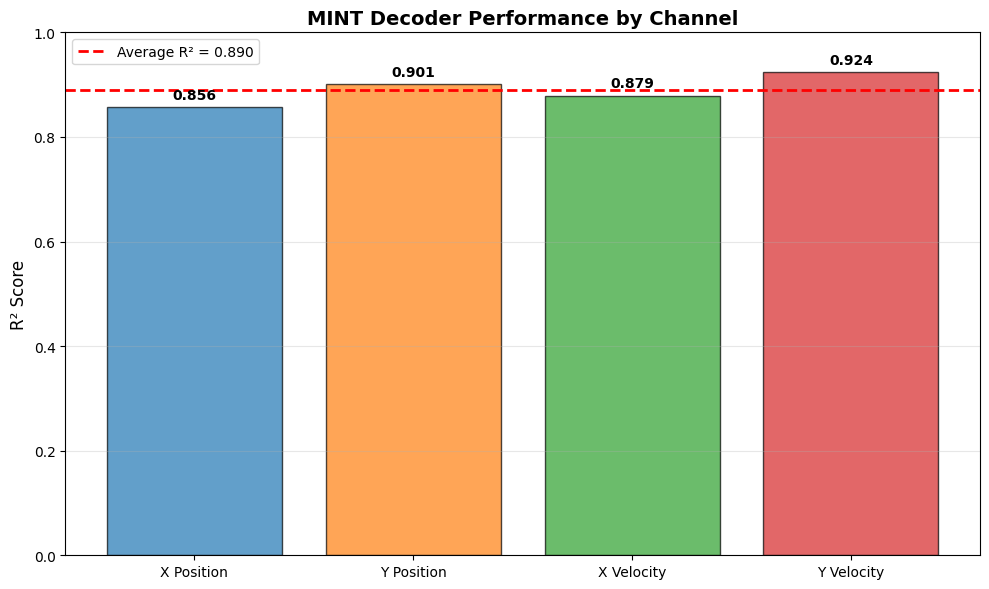

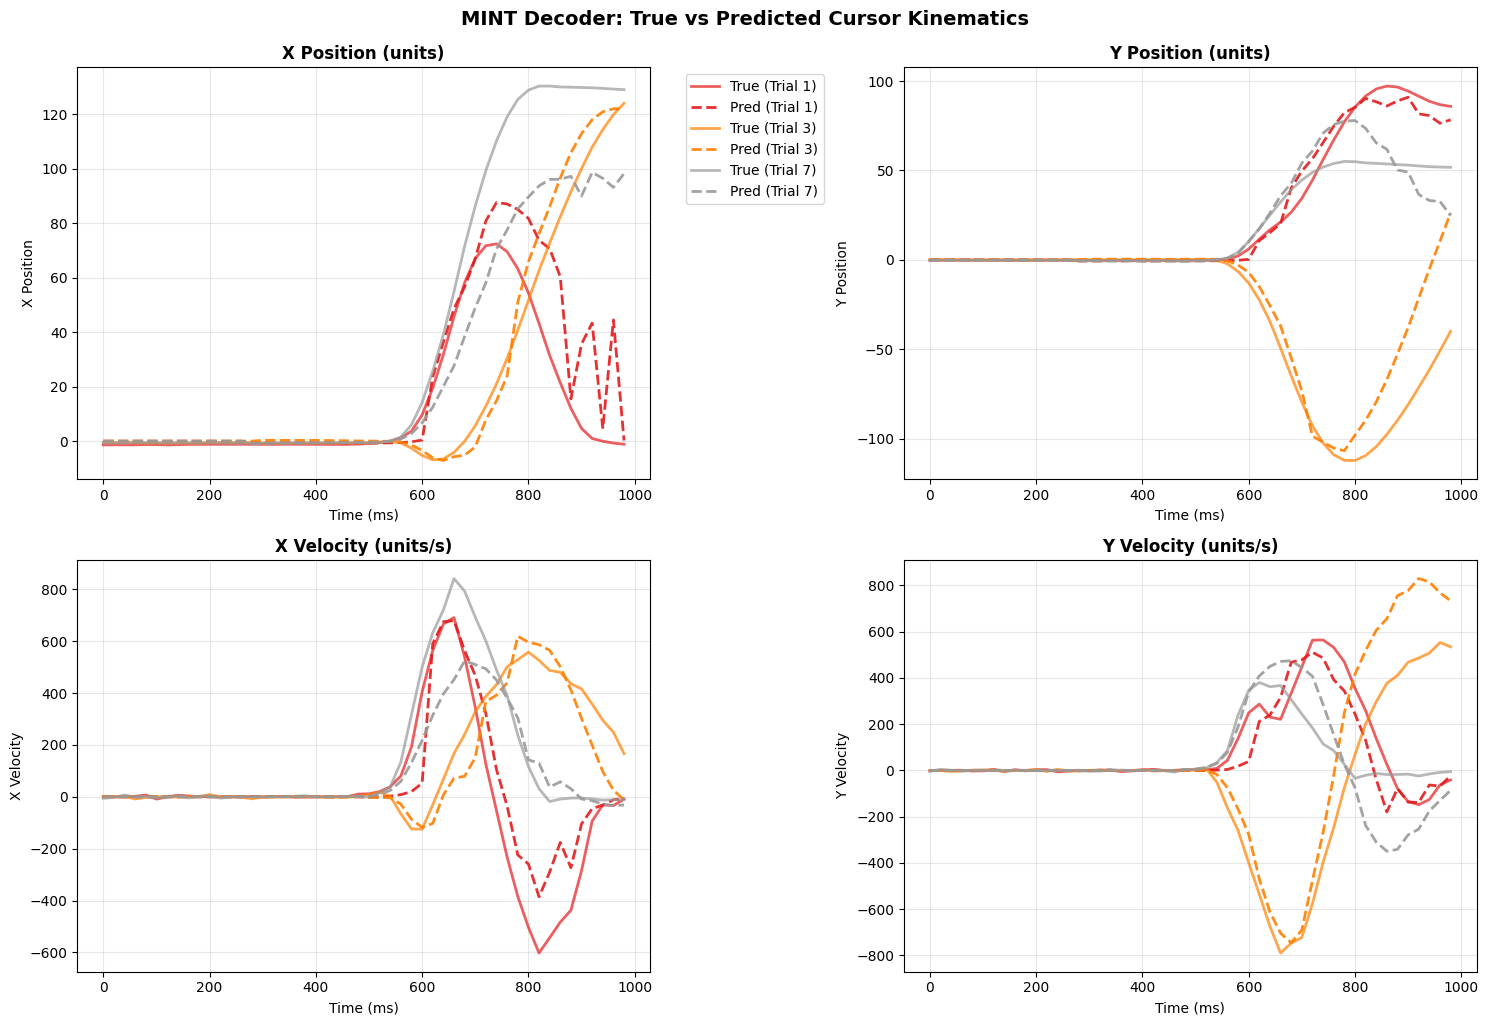

C:\Users\arthu\AppData\Local\Temp\ipykernel_34996\3848689317.py:137: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.set_xlabel('X Position'); ax2.set_ylabel('Y Position'); ax2.grid(True); ax2.legend()


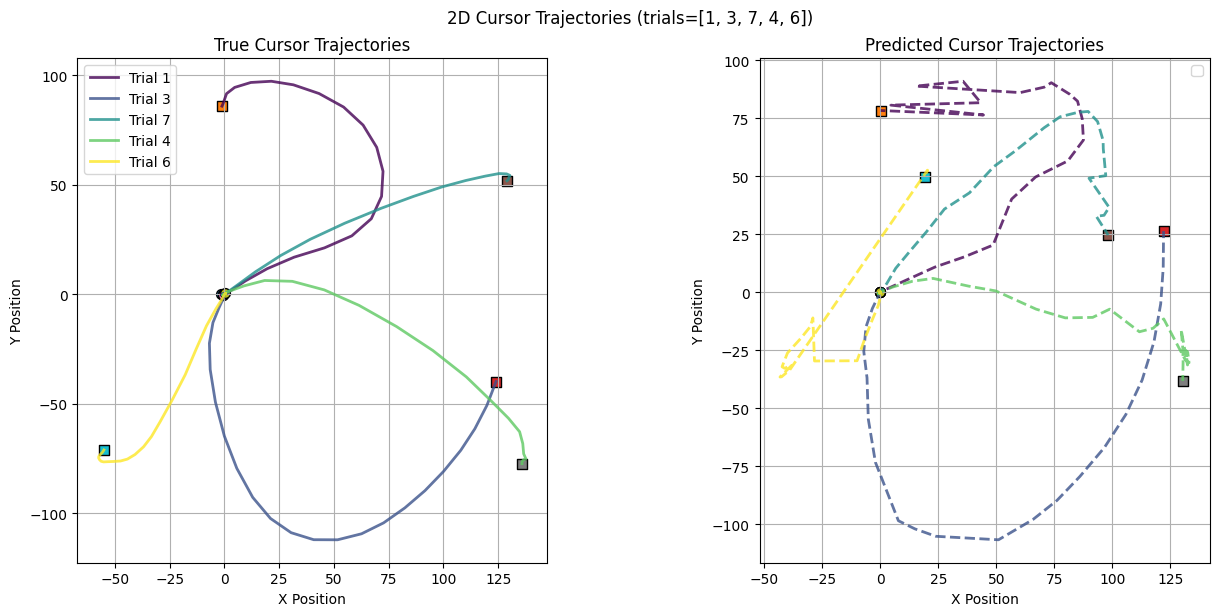

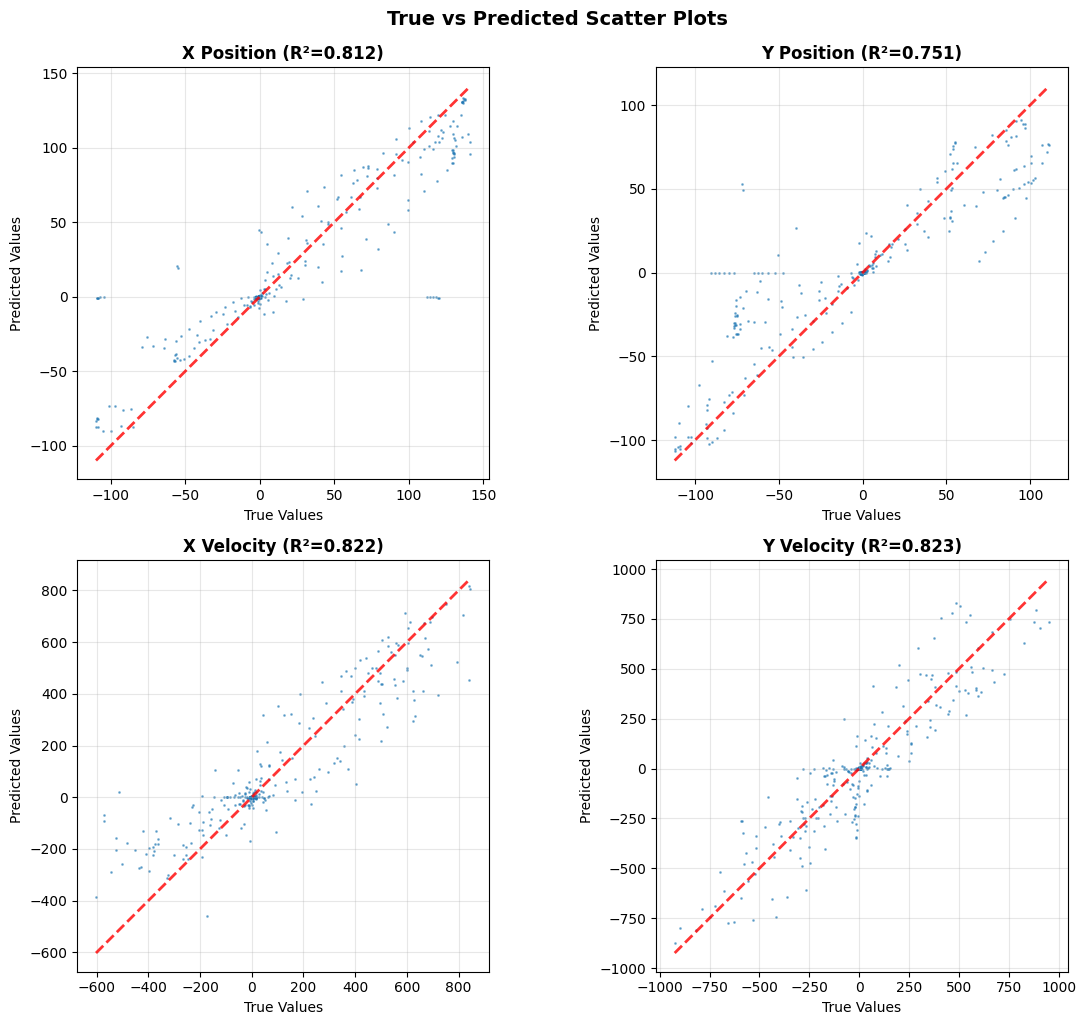

In [10]:
import numpy as np
import time

# Collect predictions for all trials
estimates = {
    "Z": [],        # list of (4, T) ground truth
    "Z_hat": [],    # list of (4, T) predictions
    "X_hat": []     # list of (N, T) neural state estimates
}

total_time = 0.0
for i, (feat_NT, beh_KT) in enumerate(zip(S_bar, Z_bar), start=1):
    t0 = time.perf_counter()
    X_hat_TN, Z_hat_TK, C_hat, K_hat, Alpha_hat = decoder.predict(feat_NT.T)
    dt = time.perf_counter() - t0
    total_time += dt

    # Store in the (4, T) orientation the viz expects
    estimates["Z"].append(beh_KT)              # already (4, T)
    estimates["Z_hat"].append(Z_hat_TK.T)      # (T, 4) -> (4, T)
    estimates["X_hat"].append(X_hat_TN.T)      # (T, N) -> (N, T)

avg_time = total_time / max(1, len(estimates["Z"]))
print(f"Avg decode time per trial: {avg_time:.3f}s")

# Calculate R² scores
try:
    bin_ms = decoder.bin_ms  # if stored on decoder
except AttributeError:
    bin_ms = 20

# Visualization functions
r2_scores = plot_r2_summary(estimates, eval_bin_size=bin_ms)
visualize_mint_predictions(estimates, best=True, bin_size=bin_ms, eval_bin_size=bin_ms)
visualize_trajectory_2d(estimates, best=True, eval_bin_size=bin_ms)
visualize_scatter_comparison(estimates, start_time_ms=200, subsample_factor=1, bin_size=bin_ms)